<a href="https://colab.research.google.com/github/c33e/closIT/blob/main/classificationprototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prototype Overview

Source available at https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=NKgMZ4bDcHf7


This project centres upon categorizing images of flowers by using a tf.keras.Sequential model, and tutorial utilizes tf.keras.utils.image_dataset_from_directory to efficiently load the data. It addresses overfitting concerns by using data augmentation and dropout techniques. It follows a standard machine learning workflow:

1.	Examine and understand the data.
2.	Build an input pipeline.
3.	Build the model.
4.	Train the model.
5.	Test the model.
6.	Improve the model and repeat the process.


# Setup & Imports

In [35]:
import matplotlib.pyplot as plt #imports
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt

# Acquiring Data

In this stage, the dataset is acquired from a designated URL through TensorFlow utilities. Following the download, a count of images encompassed in this dataset is computed and then reported. Furthermore, visual representation is provided by displaying select images from the 'roses' and 'tulips' categories, offering a small snapshot of the dataset's content.

In [36]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


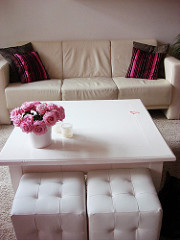

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

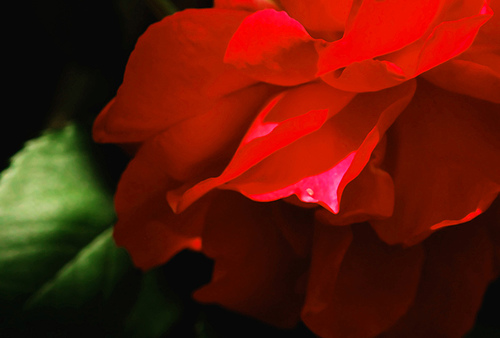

In [8]:
PIL.Image.open(str(roses[1]))

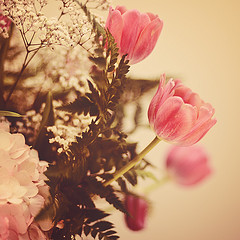

In [9]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

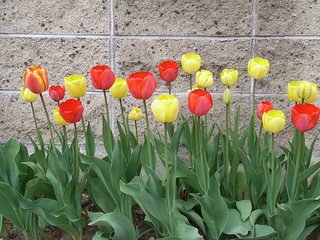

In [10]:
PIL.Image.open(str(tulips[2]))

# Pre-processing and Dataset Creation

This second phase involves the establishment of some crucial parameters; the batch size, image height, and image width. Subsequently, training and validation datasets are generated through the image_dataset_from_directory function. The printed class names contribute to the dataset's descriptive overview, and some further visual insight is provided by showcasing a subset of images from the training dataset.

In [11]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


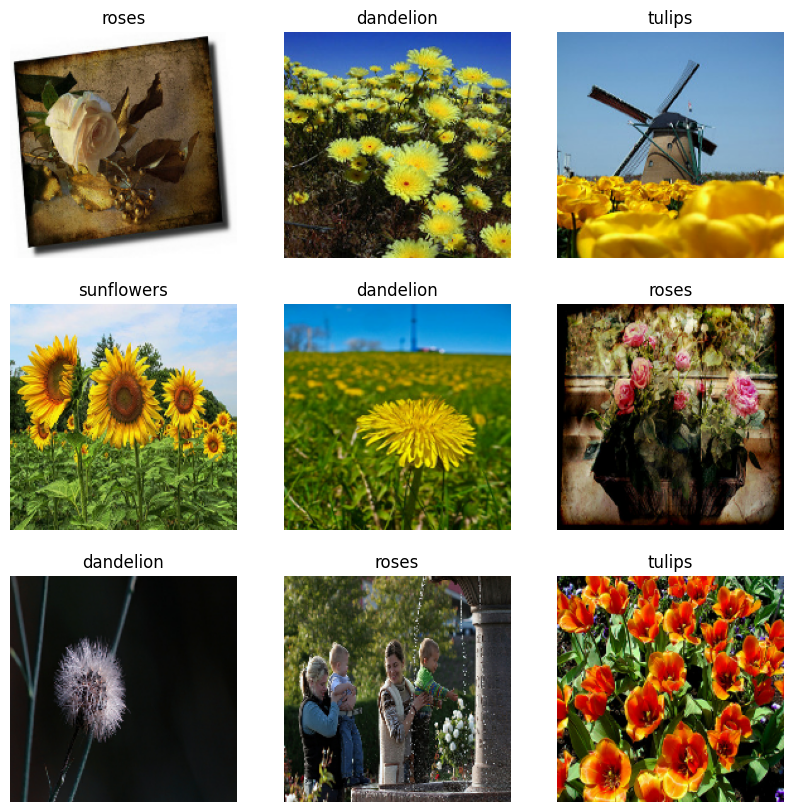

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Data Normalisation and Augmentation

Following the normalization of pixel values within the images, the third stage involves the implementation of data augmentation. This augmentation involves flips, rotations, and zooms, to fortify the model's generalisation capabilities. Then, to visually illustrate the impact of this, a representative sample of augmented images is presented.


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Model Architecture

This important stage in the prototype development involves the development of the Convolutional Neural Network (CNN) model for image classification. It is compiled using the Adam optimizer and sparse categorical cross-entropy loss. The model architecture is summarized and training, along with validation is executed over specified epochs. The progress is visualized through accuracy and loss plots. This captures the key stages of CNN model development, compilation, and training.


In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 98s 1s/step - loss: 1.3406 - accuracy: 0.4380 - val_loss: 1.1530 - val_accuracy: 0.5354
Epoch 2/10
92/92 [==============================] - 94s 1s/step - loss: 1.0244 - accuracy: 0.5817 - val_loss: 1.0248 - val_accuracy: 0.5831
Epoch 3/10
92/92 [==============================] - 98s 1s/step - loss: 0.8955 - accuracy: 0.6591 - val_loss: 0.9472 - val_accuracy: 0.6172
Epoch 4/10
92/92 [==============================] - 98s 1s/step - loss: 0.7118 - accuracy: 0.7306 - val_loss: 0.9706 - val_accuracy: 0.6253
Epoch 5/10
92/92 [==============================] - 99s 1s/step - loss: 0.5037 - accuracy: 0.8260 - val_loss: 1.0554 - val_accuracy: 0.6240
Epoch 6/10
92/92 [==============================] - 95s 1s/step - loss: 0.3259 - accuracy: 0.8944 - val_loss: 1.1881 - val_accuracy: 0.6608
Epoch 7/10
92/92 [==============================] - 97s 1s/step - loss: 0.1763 - accuracy: 0.9465 - val_loss: 1.3013 - val_accuracy: 0.6390
Epoch 8/10
92/92 [==

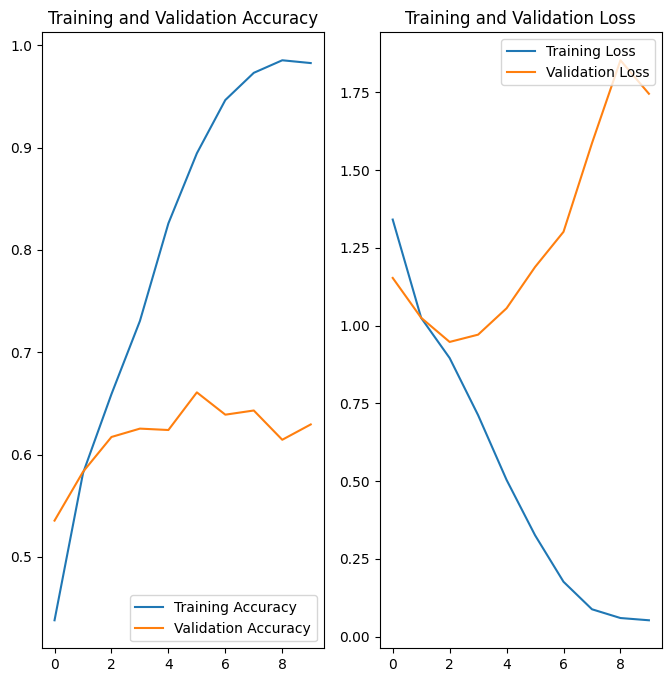

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Refinement

This process works to enhance the model by incorporating a dropout layer for improved regularization. The model is then recompiled and trained over an extended number of epochs. The resulting training and validation accuracy and loss are visualized through updated plots.


In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

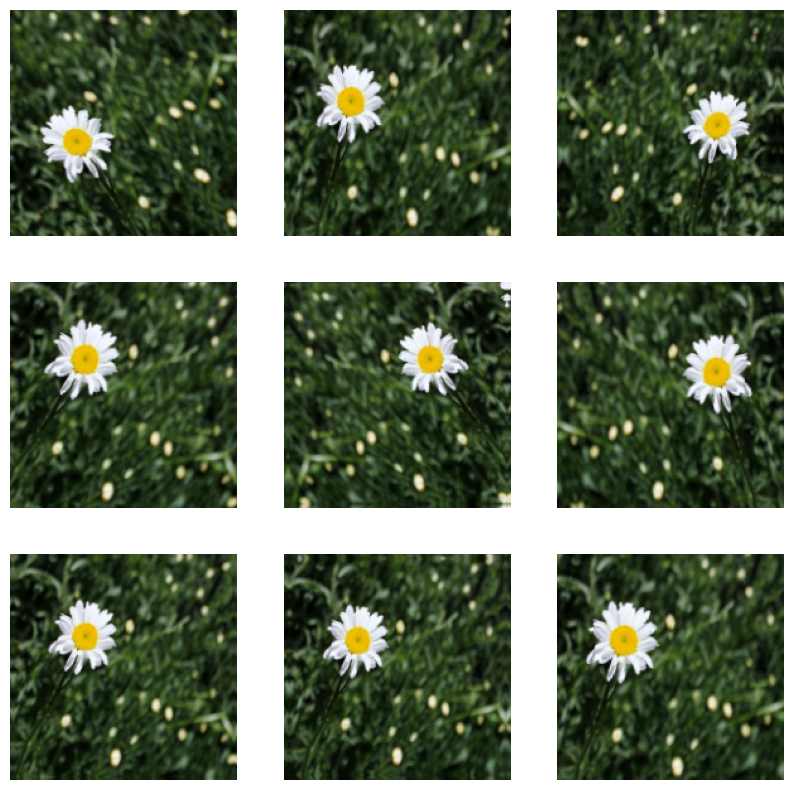

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [23]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [25]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 118s 1s/step - loss: 1.4398 - accuracy: 0.3692 - val_loss: 1.1825 - val_accuracy: 0.4714
Epoch 2/15
92/92 [==============================] - 112s 1s/step - loss: 1.0608 - accuracy: 0.5661 - val_loss: 1.0238 - val_accuracy: 0.5899
Epoch 3/15
92/92 [==============================] - 117s 1s/step - loss: 0.9721 - accuracy: 0.6110 - val_loss: 0.8974 - val_accuracy: 0.6512
Epoch 4/15
92/92 [==============================] - 116s 1s/step - loss: 0.8851 - accuracy: 0.6482 - val_loss: 0.9690 - val_accuracy: 0.6199
Epoch 5/15
92/92 [==============================] - 116s 1s/step - loss: 0.8309 - accuracy: 0.6778 - val_loss: 0.8278 - val_accuracy: 0.6662
Epoch 6/15
92/92 [==============================] - 112s 1s/step - loss: 0.7719 - accuracy: 0.7006 - val_loss: 0.8301 - val_accuracy: 0.6771
Epoch 7/15
92/92 [==============================] - 118s 1s/step - loss: 0.7288 - accuracy: 0.7183 - val_loss: 0.7980 - val_accuracy: 0.6907
Epoch 8/15
92

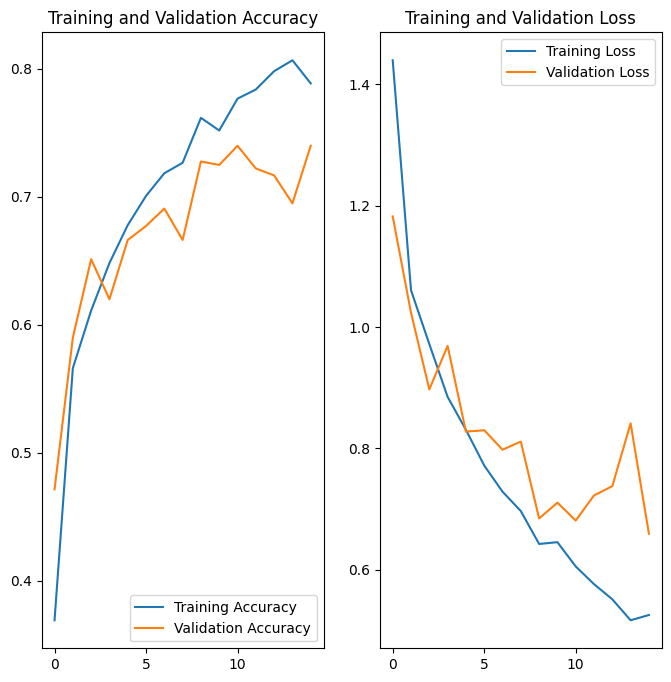

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Inference with New Image

This stage uses the trained model to classify the class of a new image (a red sunflower) obtained from a specified URL.

In [27]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 127ms/step
This image most likely belongs to sunflowers with a 99.84 percent confidence.


# Tensorflow Lite Inference

Now, the model is converted into TensorFlow Lite format and subsequently saved. Following this, the TensorFlow Lite model is loaded using an interpreter. Inference is executed on a consistent sunflower image using the TensorFlow Lite model. Lastly, a comparison is conducted between the predictions generated by the original model and the TensorFlow Lite model and presented.


In [29]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [31]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [32]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [33]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 99.84 percent confidence.


In [34]:
print(np.max(np.abs(predictions - predictions_lite)))

1.9073486e-06
